# Mammalian cells pathway occupancy, Extended Data Fig 8 c and f

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy as scipy
import math 
from tqdm.auto import tqdm
import re

In [2]:
# don't print warning messages
import warnings
warnings.filterwarnings('ignore')

### Inital data wranggling

In [3]:
#read in proteomics datasets 
mammalian_proteomics = pd.read_csv('./data/2024_01_08_mammalian_proteomics.csv')

#read in gene inclusion list for fermentation and respiration
mammalian_inclusion = pd.read_csv('./data/mammalian_inclusion.csv')

#read in mitocarta mitochondrial protein inclusion list 
mitocarta = pd.read_csv('./data/mitocarta_mito_list.csv')

### ETC Correction

In [4]:
#ensure the 'Gene name' column is a string to handle the split operation
mammalian_proteomics['Gene name'] = mammalian_proteomics['Gene name'].astype(str)

# Create a function to explode the 'Gene name' column based on ";" delimiter
def explode_gene_names(df, column='Gene name'):
    return (
        df.drop(column, axis=1)
        .join(
            df[column].str.split(';', expand=True)
            .stack()
            .reset_index(level=1, drop=True)
            .rename(column)
        )
        .reset_index(drop=True)
    )

#explode the mammalian_proteomics dataframe on Gene name
exploded_proteomics = explode_gene_names(mammalian_proteomics)

#filter out rows with 'nan' in 'Gene name'
exploded_proteomics = exploded_proteomics[exploded_proteomics['Gene name'] != 'nan']

#merge with mammalian_inclusion to get pathway, MW, and EC number
merged_df = pd.merge(exploded_proteomics, mammalian_inclusion[['Gene name', 'pathway', 'MW', 'EC number']], on='Gene name', how='left')

#drop duplicates
df_all = merged_df.drop_duplicates(subset=['Gene name'])

In [5]:
#drop columns
variables_list = [col for col in df_all.columns if col not in ['Gene name', 'pathway', 'MW', 'EC number']]

In [6]:
#melt df
df_all_melt = pd.melt(df_all, id_vars=['Gene name', 'pathway', 'MW', 'EC number'],
                                 value_vars=variables_list)

In [7]:
#fill na with zeros
total_inclusion_etc = (
    df_all_melt.loc[df_all_melt['pathway'].str.contains('etc|atp', case=False, na=False)]
    .assign(value=lambda x: x['value'].fillna(0))
)

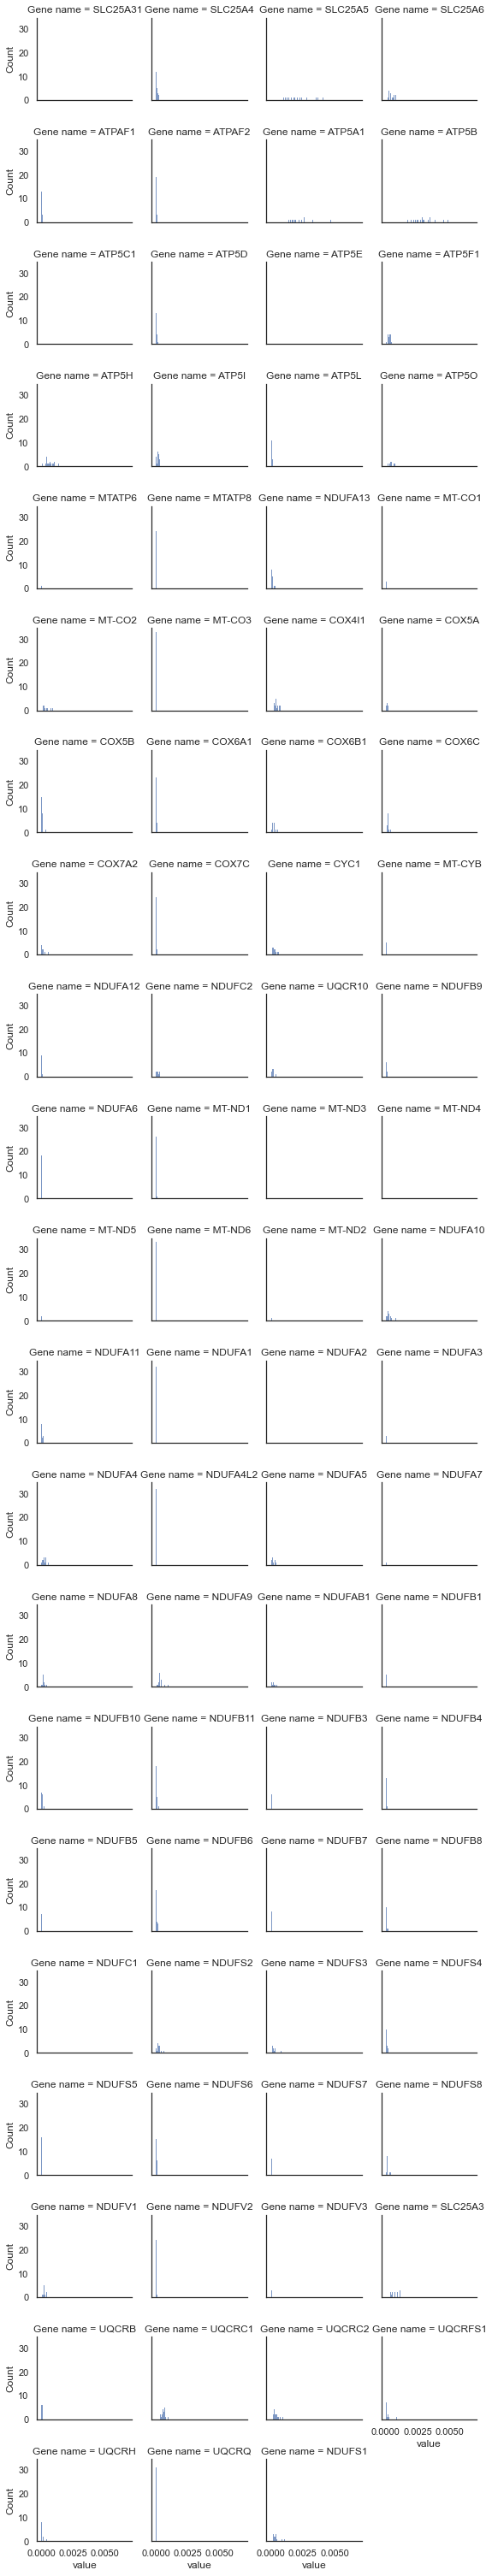

In [8]:
#hist plot
sns.set_theme(style="white")
sns.displot(
    total_inclusion_etc, x="value", col="Gene name",
    height=2, facet_kws=dict(margin_titles=True),
    col_wrap=4)

In [9]:
#calculate the fraction of zero (or near-zero) values for each gene
def calculate_fraction_zero(group):
    fraction_zero = (group['value'] <= 0.00001).mean()
    return pd.Series({'Fraction Zero': fraction_zero, 'Flag': fraction_zero >= 0.2})

#apply the function to each group
df_zero = total_inclusion_etc.groupby('Gene name').apply(calculate_fraction_zero).reset_index()

#splitting the genes based on the flag
geneCorrect = df_zero.loc[df_zero['Flag'], 'Gene name'].tolist()
geneTruth = df_zero.loc[~df_zero['Flag'], 'Gene name'].tolist()

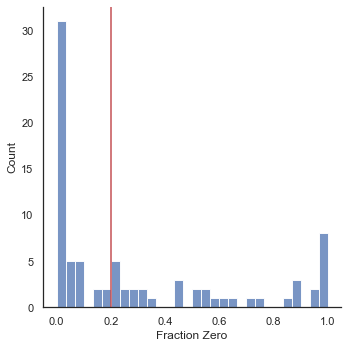

In [10]:
#plot hist
sns.set_theme(style="white")
sns.displot(
    df_zero, x="Fraction Zero", bins = 30)
plt.axvline(0.2, color='r')

In [11]:
#calculating correction value
geneMassOccupation = []
dataset = total_inclusion_etc
condition_list = dataset['variable'].unique()
d = {'variable': [], 'correction_value': []}
df = pd.DataFrame(data=d)

for condition in condition_list: 
    #print(condition)
    dataset_temp = dataset.loc[dataset['variable'] == condition]
    
    MWoccupany = []
    for gene in geneTruth: 
        #print(gene)
        gene_temp = dataset_temp.loc[dataset_temp['Gene name'] == gene]
        gene_temp_value = gene_temp['value'] / gene_temp['MW']
        
        #MWoccupany.append(gene_temp_value)
        #print(MWoccupany)    
        #meanMWoccupany = np.mean(MWoccupany)
        df2 = pd.DataFrame({'variable': [condition], 'correction_value': [gene_temp_value.iloc[0]], 'Gene name': [gene]})
        df = pd.concat([df, df2])

In [12]:
#prepare `ec_number` DataFrame first to ensure it's ready for merging.
ec_number = total_inclusion_etc[['Gene name', 'EC number']].drop_duplicates()

#merge to add 'EC number' to your loop-constructed `df` only after it's fully constructed.
df = pd.merge(df, ec_number, on='Gene name', how='left')

# ec number as str
df['EC number'] = df['EC number'].astype(str) 

#drop duplicates
ec_number = total_inclusion_etc[['Gene name', 'EC number']].drop_duplicates()

#make a condition list
condition_list = df['variable'].unique()

# Pivot the data to have conditions as columns and EC numbers as rows
# This step aggregates data by EC number and calculates the mean correction value for each condition
pivot_df = df.pivot_table(index='EC number', columns='variable', values='correction_value', aggfunc='mean').reset_index()

#melt the pivot table back to a long format with condition names and their corresponding correction values
df_correction = pivot_df.melt(id_vars=['EC number'], var_name='variable', value_name='correction_value')

#merge and drop duplicates
df_correction = pd.merge(df_correction, df[['EC number', 'Gene name', 'variable']], on=['EC number', 'variable'], how='left').drop_duplicates()

In [13]:
#df subset
df_correction = df_correction[['variable', 'correction_value', 'EC number']]

In [14]:
#filter total_inclusion_etc DataFrame for rows where 'Gene name' is in geneCorrect list
genes_to_correct = total_inclusion_etc[total_inclusion_etc['Gene name'].isin(geneCorrect)]

#merge the filtered df with df_correction on 'variable' and 'EC number' columns
genes_to_correct = pd.merge(genes_to_correct, df_correction, on=['variable', 'EC number'], how='left')

# Calculate 'corrected_value' by multiplying 'correction_value' by 'MW'
genes_to_correct['corrected_value'] = genes_to_correct['correction_value'] * genes_to_correct['MW']

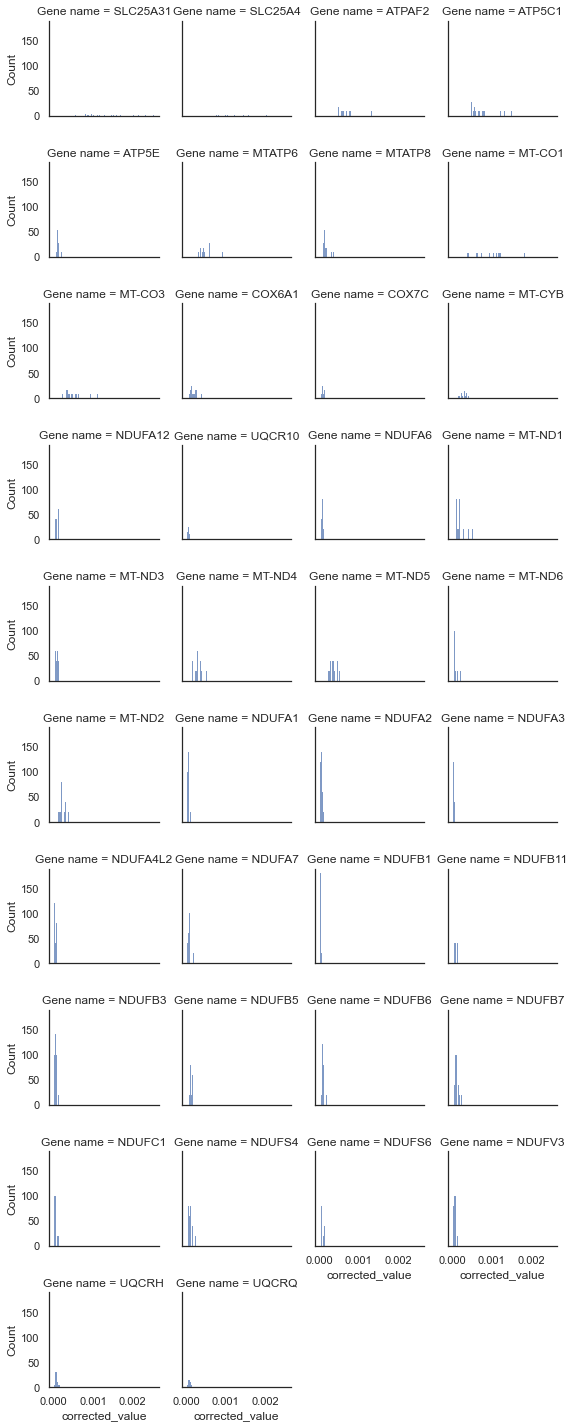

In [15]:
#plot corrected genes histogram
sns.set_theme(style="white")
sns.displot(genes_to_correct, x="corrected_value", col="Gene name",
    height=2, facet_kws=dict(margin_titles=True),
    col_wrap=4)

In [16]:
for variable in genes_to_correct['variable'].unique():
    aggregated_corrections = genes_to_correct.loc[genes_to_correct['variable'] == variable] \
                                .groupby('Gene name')['corrected_value'] \
                                .mean() 
    
    #apply aggregated corrections to mammalian_proteomics
    for gene, corrected_value in aggregated_corrections.iteritems():
        mammalian_proteomics.loc[mammalian_proteomics['Gene name'] == gene, variable] = corrected_value

#normalize excluding Gene name
mammalian_proteomics.iloc[:, 1:] = mammalian_proteomics.iloc[:, 1:].div(mammalian_proteomics.iloc[:, 1:].sum())

## Fermentation

In [17]:
#unique gene names
unique_symbols = set(mammalian_inclusion.loc[mammalian_inclusion['meta_pathway'] == 'fermentation']['Gene name'].unique())

#check if any gene matches mitocarta
def gene_in_ferm(gene_row):
    gene_list = gene_row.split(";")
    return any(gene in unique_symbols for gene in gene_list)

#apply the function to each row to create a boolean mask
mask = mammalian_proteomics['Gene name'].apply(gene_in_ferm)

#filter mammalian_coexpression using the mask
fermentation_genes = mammalian_proteomics[mask]

In [18]:
#melt df
mammalian_proteomics_ferm = pd.melt(fermentation_genes, id_vars=['Gene name'],
                                 value_vars=variables_list)

In [19]:
#groupby dataset variable and sum the entire set of genes
mammalian_proteomics_ferm_occupancy = mammalian_proteomics_ferm.groupby('variable').sum().reset_index()
mammalian_proteomics_ferm_occupancy['estimate'] = 'fermentation'
mammalian_proteomics_ferm_occupancy['organism'] = 'mammalian'

In [20]:
#mean occupancy
mammalian_proteomics_ferm_occupancy.mean()

value    0.043132
dtype: float64

In [21]:
#save df to csv
mammalian_proteomics_ferm_occupancy.to_csv('./data/2024_02_26_mammalian_specific_actvity_ferm.csv')

## Respiration

#### Full mito

In [22]:
#ensure the Symbol column in mitocarta is of string type
mitocarta['Symbol'] = mitocarta['Symbol'].astype(str)

#create a set of unique symbols for faster lookup
unique_symbols = set(mitocarta['Symbol'])

#function to check if any gene in matches a symbol in mitocarta
def gene_in_mitocarta(gene_row):
    gene_list = gene_row.split(";")
    return any(gene in unique_symbols for gene in gene_list)

#apply the function to each row in 'Gene name' to create a boolean mask
mask = mammalian_proteomics['Gene name'].apply(gene_in_mitocarta)

#filter mammalian_coexpression using the mask
full_mito = mammalian_proteomics[mask]

In [23]:
#melt df
mammalian_proteomics_full_mito = pd.melt(full_mito, id_vars=['Gene name'],
                                 value_vars=variables_list)

In [24]:
#groupby dataset variable and sum the entire set of genes
mammalian_proteomics_full_mito_occupancy = mammalian_proteomics_full_mito.groupby('variable').sum().reset_index()
mammalian_proteomics_full_mito_occupancy['estimate'] = 'respiration'
mammalian_proteomics_full_mito_occupancy['organism'] = 'mammalian'

In [25]:
#mean occupancy
mammalian_proteomics_full_mito_occupancy.mean()

value    0.113997
dtype: float64

In [26]:
#save to csv
mammalian_proteomics_full_mito_occupancy.to_csv('./data/2024_02_26_mammalian_specific_actvity_resp_full_mito.csv')

#### Partial mito

In [27]:
#extract unique Gene name values in respiration pathway
respiration_gene_list = mammalian_inclusion[mammalian_inclusion['meta_pathway'] == 'respiration']['Gene name'].unique()

In [28]:
#convert gene names in mammalian_proteomics to a string
mammalian_proteomics['Gene name'] = mammalian_proteomics['Gene name'].astype(str)

In [29]:
#check if any gene in a row's field matches the respiration gene list
def check_respiration_gene(gene_row):
    gene_list = gene_row.split(";")  #split the gene names
    gene_list = [x for x in gene_list if x != 'nan']  #remove na entries
    return any(gene in respiration_gene_list for gene in gene_list)  #check if any gene matches

#apply the function to each row in column and filter the dataframe
human_proteomics_resp = mammalian_proteomics[mammalian_proteomics['Gene name'].apply(check_respiration_gene)]

In [30]:
def geneCoexpression(proteomics_dataset, core_list, merger, columns_to_drop):
    
    #core_list = core_list.drop(columns = columns_to_drop)
    core_list = core_list.set_index('Gene name')
    core_list_t = core_list.transpose()
    core_list_t["Core_Sum"] = core_list_t.sum(axis=1)
    core_list_t = core_list_t[["Core_Sum"]]
    core_list_sum = core_list_t.transpose()
    core_list_sum.reset_index(inplace = True)
    core_list_sum = core_list_sum.set_index('Gene name')
    proteomics_dataset = proteomics_dataset.set_index('Gene name')
    yeast_proteomics_with_core = pd.concat([core_list_sum, proteomics_dataset])
    yeast_proteomics_with_core_t = yeast_proteomics_with_core.transpose()
    column_list = yeast_proteomics_with_core_t.columns
    yeast_proteomics_with_core_t = yeast_proteomics_with_core_t.loc[:,~yeast_proteomics_with_core_t.columns.duplicated()]
    
    gene_name = []
    r_value = []
    p_value = []

    #calculates the Pearson correlation and p value for each gene with the core sum 
    for gene in column_list: 

        x = yeast_proteomics_with_core_t['Core_Sum'].values
        y = yeast_proteomics_with_core_t[gene].values

        bad = ~np.logical_or(np.isnan(x), np.isnan(y))

        test1 = np.compress(bad, x)  
        test2 = np.compress(bad, y)  

        r, p = scipy.stats.pearsonr(test1, test2)
        #print(p)
        #print(r)
    
        gene_name.append(gene)
        r_value.append(r)
        p_value.append(p)
    
    d = {'Gene name': gene_name, 'R value': r_value, 'P value': p_value}
    df = pd.DataFrame(data=d)
    
    df = df.sort_values('P value')
    df = df.reset_index(drop = True)
    
    #bonferroni correction
    df['Bon'] = df['P value'] * len(df) 
    #benjamini hochberg correction
    df['BH'] = df['P value'] * len(df) / (df.index + 1)
    
    
    return(df)
    

In [31]:
#exacting the function on the proteomics data 
mammalian_columns_to_drop = []

mammalian_coexpression = geneCoexpression(mammalian_proteomics, human_proteomics_resp, human_proteomics_resp, mammalian_columns_to_drop)

In [32]:
mammalian_coexpression.to_csv('./data/mammalian_coexpression.csv')

In [33]:
#ensure gene name is a string
mammalian_coexpression['Gene name'] = mammalian_coexpression['Gene name'].astype(str)

#split into lists of genes
mammalian_coexpression['Gene List'] = mammalian_coexpression['Gene name'].str.split(";")

#set of genes in mitocarta for efficient lookup
mitocarta_genes = set(mitocarta['Symbol'].astype(str))

#create a boolean mask (true if any gene in the gene list is in mitocarta_genes)
mask = mammalian_coexpression['Gene List'].apply(lambda genes: any(gene in mitocarta_genes for gene in genes))

#apply mask to filter the df
df_mito_for_table = mammalian_coexpression[mask].copy()

#drop gene list column
df_mito_for_table.drop(columns=['Gene List'], inplace=True)

In [34]:
#list of correlated mito genes
mammalian_coexpression_sig = mammalian_coexpression.loc[(mammalian_coexpression['R value'] >= 0) & (mammalian_coexpression['BH'] < 0.05)]

In [35]:
#extract the correlated mito genes from the mitocarta list
df_mito = pd.DataFrame()

for idx, row in mammalian_coexpression_sig.iterrows():
    gene_list = row['Gene name'].split(";")
    for gene in gene_list:
        if mitocarta['Symbol'].str.contains(f'^{gene}$').any():
            df_mito = pd.concat([df_mito, mammalian_coexpression_sig.loc[[idx]]], ignore_index=True)

In [36]:
#merge the correlated mito genes with the proteomics list
mito_inclusion = pd.merge(df_mito, mammalian_proteomics, on = 'Gene name', how = 'left')

ferm_list = set(mammalian_inclusion.loc[mammalian_inclusion['meta_pathway'] == 'fermentation']['Gene name'].unique())

#remove any ferm genes from mito list to avoid double counting in ATP-producing proteome space
for gene in ferm_list: 
    #print(ORF)
    mito_inclusion = mito_inclusion.loc[~(mito_inclusion['Gene name'] == gene)]

In [37]:
#combine the two DataFrames
mammalian_resp_sa_partial_mito = pd.concat([human_proteomics_resp, mito_inclusion])
mammalian_resp_sa_partial_mito.drop_duplicates('Gene name', inplace=True)

In [38]:
#melt df
mammalian_resp_sa_partial_mito_melt = pd.melt(mammalian_resp_sa_partial_mito, id_vars=['Gene name'],
                                 value_vars=variables_list)

In [39]:
#groupby dataset variable and sum the entire set of genes
mammalian_resp_sa_partial_mito_melt_sum = mammalian_resp_sa_partial_mito_melt.groupby('variable').sum().reset_index()
mammalian_resp_sa_partial_mito_melt_sum['estimate'] = 'respiration'
mammalian_resp_sa_partial_mito_melt_sum['organism'] = 'mammalian'

In [40]:
#mean occupancy
mammalian_resp_sa_partial_mito_melt_sum.mean()

value    0.074584
dtype: float64

In [41]:
#save df to csv
mammalian_resp_sa_partial_mito_melt_sum.to_csv('./data/2024_02_26_mammalian_specific_actvity_resp_partial_mito.csv')

#### Core mito

In [42]:
#unique gene names
unique_symbols = set(mammalian_inclusion.loc[mammalian_inclusion['meta_pathway'] == 'respiration']['Gene name'].unique())

#function to check if any gene in Gene name matches a symbol in the proteomics dataset
def gene_in_resp(gene_row):
    gene_list = gene_row.split(";")
    return any(gene in unique_symbols for gene in gene_list)

#apply the function to each row in Gene name to create a boolean mask
mask = mammalian_proteomics['Gene name'].apply(gene_in_resp)

#filter mammalian_coexpression using the mask
respiration_genes = mammalian_proteomics[mask]

In [43]:
#melt df
mammalian_proteomics_resp = pd.melt(respiration_genes, id_vars=['Gene name'],
                                 value_vars=variables_list)

In [44]:
#drop dulpicates
mammalian_proteomics_resp.drop_duplicates(inplace = True)

In [45]:
#groupby dataset variable and sum the entire set of genes
mammalian_proteomics_resp_core_occupancy = mammalian_proteomics_resp.groupby('variable').sum().reset_index()
mammalian_proteomics_resp_core_occupancy['estimate'] = 'respiration'
mammalian_proteomics_resp_core_occupancy['organism'] = 'mammalian'

In [46]:
#mean occupancy
mammalian_proteomics_resp_core_occupancy.mean()

value    0.028368
dtype: float64

In [47]:
#save df to csv
mammalian_proteomics_resp_core_occupancy.to_csv('./data/2024_02_26_mammalian_specific_actvity_resp_core.csv')

### Total ATP-producing space

#### ATP Full Mito

In [48]:
#concat full mito and ferm occupancy
atp_occupancy_full_mito = pd.concat([mammalian_proteomics_full_mito_occupancy, mammalian_proteomics_ferm_occupancy]).groupby('variable').sum().reset_index()

In [49]:
#mean occupancy
atp_occupancy_full_mito.mean()

value    0.157129
dtype: float64

In [50]:
#save df to csv
atp_occupancy_full_mito.to_csv('./data/2024_02_26_mammalian_atp_total_full_mito.csv')

#### ATP Partial Mito

In [51]:
#concat partial mito and ferm occupancy
atp_occupancy_partial_mito = pd.concat([mammalian_resp_sa_partial_mito_melt_sum, mammalian_proteomics_ferm_occupancy]).groupby('variable').sum().reset_index()
atp_occupancy_partial_mito['estimate'] = 'total'
atp_occupancy_partial_mito['organism'] = 'mammalian'

In [52]:
#mean occupancy
atp_occupancy_partial_mito.mean()

value    0.117716
dtype: float64

In [53]:
#save df to csv
atp_occupancy_partial_mito.to_csv('./data/2024_02_26_mammalian_atp_total_partial_mito.csv')

#### ATP Core Resp

In [54]:
#concat core mito and ferm occupancy
atp_occupancy_core = pd.concat([mammalian_proteomics_resp_core_occupancy, mammalian_proteomics_ferm_occupancy]).groupby('variable').sum().reset_index()
atp_occupancy_core['estimate'] = 'total'
atp_occupancy_core['organism'] = 'mammalian'

In [55]:
#mean occupancy
atp_occupancy_core.mean()

value    0.071501
dtype: float64

In [56]:
#save df to csv
atp_occupancy_core.to_csv('./data/2024_02_26_mammalian_atp_total_core.csv')

## Occupancy Across Cell Lines

In [57]:
#create a temporary df from the split operation
temp_df = atp_occupancy_core['variable'].str.replace('LFQ Intensity ', '').str.split('_', expand=True)

#ensure there are always two columns, fill missing values if necessary
temp_df[1] = temp_df[1] if 1 in temp_df.columns else None

#assign the results back to the original df
atp_occupancy_core[['cell line', 'rep']] = temp_df[[2, 3]]

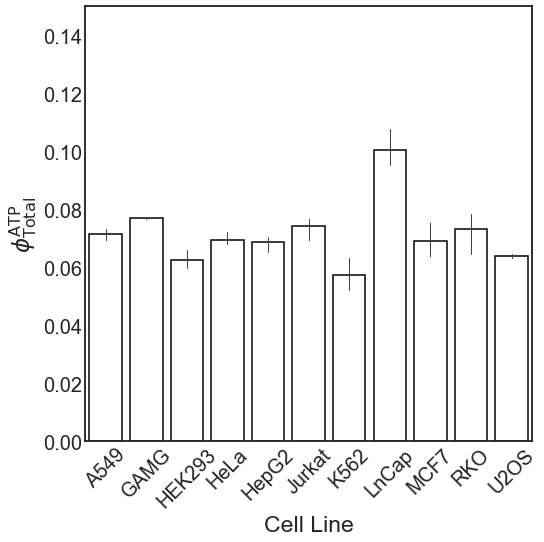

In [58]:
#order = mammalian_proteomics_sum.groupby('cell line')['value'].mean().sort_values(ascending=False).index

#set sns theme
sns.set_context("talk")

#create a bar plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.patch.set_facecolor('white')

#bar plot
sns.barplot(x='cell line', y='value', data=atp_occupancy_core, color = 'white', edgecolor='black', linewidth=1.5, zorder=2, errwidth=1)

#set the limits and labels
ax.set_ylim(0, 0.15)  # Adjust as needed
# ax.set_xlim(.14, 0.43)  # Uncomment and adjust if needed for x-axis
ax.set_xlabel("Cell Line", fontsize=23)
ax.set_ylabel("Value", fontsize=23)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel(r"$\phi_{\mathrm{Total}}^{\mathrm{ATP}}$", fontsize=23)

#customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=20, length=0)

#save the figure
fig.savefig('./Figures/edf8c_mammalian_atp_total.svg', format='svg', dpi=1200)

# Mammalian Translation

In [59]:
#translation df
mammalian_translation_inclusion = pd.read_csv('./data/2024_01_27_mammalian_translation.csv')

In [60]:
#rename column
mammalian_translation_inclusion.rename(columns = {'Gene' : 'Gene name'}, inplace = True)

In [61]:
#find gene names from translation inclusion in proteomics
translation_gene_list = mammalian_translation_inclusion['Gene name'].unique()

df_translation = pd.DataFrame()
df_pathway = pd.DataFrame()

i=0
for row in tqdm(range(len(mammalian_proteomics))): 
    gene_row = mammalian_proteomics.loc[mammalian_proteomics.index[row], 'Gene name']
    gene_row = str(gene_row)
    #print(row)
    #print(gene_row)
    gene_list = gene_row.split(";")
    #print()
    gene_list = [x for x in gene_list if x != 'nan']
    #print(gene_list)
    i=i+1

    if any(gene in gene_list for gene in translation_gene_list):
        #print(geiger_2012_proteomics.iloc[[i-1]])
        subset = mammalian_proteomics.iloc[[i-1]]
        
        for gene in gene_list: 
            gene_pathway = mammalian_inclusion.loc[mammalian_inclusion['Gene name'] == gene]
            gene_pathway = gene_pathway[['Gene name', 'pathway']]
            gene_pathway.reset_index(inplace = True)
            if not gene_pathway.empty: 
                #print(gene_pathway['pathway'][0])
                subset['pathway'] = gene_pathway['pathway'][0]
             
        df_translation = pd.concat([df_translation, subset])

  0%|          | 0/10656 [00:00<?, ?it/s]

In [62]:
#melt df
mammalian_proteomics_translation = pd.melt(df_translation, id_vars=['Gene name'],
                                 value_vars=variables_list)

In [63]:
#sum of occupancy for proteins in translation inclusion
mammalian_translation_sum = mammalian_proteomics_translation.groupby(['variable']).sum()

In [64]:
#reset
mammalian_translation_sum.reset_index(inplace = True)

In [65]:
#create a temporary DataFrame from the split operation
temp_df = mammalian_translation_sum['variable'].str.replace('LFQ Intensity ', '').str.split('_', expand=True)

#ensure there are always two columns, fill missing values if necessary
temp_df[1] = temp_df[1] if 1 in temp_df.columns else None

#assign the results back to the original df
mammalian_translation_sum[['cell line', 'rep']] = temp_df[[2, 3]]

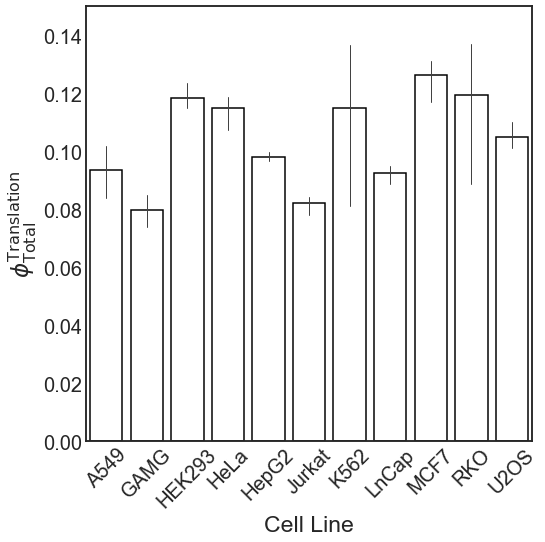

In [66]:
#order = mammalian_translation_sum.groupby('cell line')['value'].mean().sort_values(ascending=False).index

#set the context for larger plot elements
sns.set_context("talk")

#create a bar plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.patch.set_facecolor('white')

#bar plot
sns.barplot(x='cell line', y='value', data=mammalian_translation_sum, color = 'white', edgecolor='black', linewidth=1.5, zorder=2, errwidth=1)

#set the limits and labels
ax.set_ylim(0, 0.15)  # Adjust as needed
# ax.set_xlim(.14, 0.43)  # Uncomment and adjust if needed for x-axis
ax.set_xlabel("Cell Line", fontsize=23)
ax.set_ylabel("Value", fontsize=23)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel(r"$\phi_{\mathrm{Total}}^{\mathrm{Translation}}$", fontsize=23)

#customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=20, length=0)

#save fig
fig.savefig('./Figures/edf8f_mammalian_translation_total.svg', format='svg', dpi=1200)